# Обзор данных ERA5-Land

***

## Срез данных
Все данные (2017-2022) всех штатов весят больше 1 тб. Поэтому отберем следующие:
- Данные за *2017-2022* годы.
- Данные по следующим культурам: *Кукуруза*.
- Данные для штатов: *Айова, Иллинойс* ("IA", "IL").

***

## Описание

[ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview) - это реанализ данных с повышенным разрешением, описывающий изменения параметров земной поверхности за несколько десятилетий. Он создан на основе перерасчета земного компонента климатического реанализа ECMWF ERA5, объединяющего модели и наблюдения в глобальный согласованный набор данных с использованием физических законов.

Как и любая модель, ERA5-Land содержит погрешности, особенно для ранних периодов, когда наблюдений меньше.

Для данного проекта были взяты данные за 2018-2021 гг. для штатов IA и IL за каждые 1, 8, 15, 23 день каждого месяца в 11:00. Такие дни выбраны не случайно: 1, 15 - съемки Sentinel одной локации, остальные даты для улучшения оценки.

| Характеристика         | Описание                                                                 |
|------------------------|--------------------------------------------------------------------------|
| Тип данных             | Сеточные данные                                                          |
| Проекция              | Регулярная широтно-долготная сетка                                       |
| Пространственный охват| Глобальный                                                               |
| Горизонтальное разрешение | 0.1° × 0.1°; Нативное разрешение — 9 км                              |
| Вертикальный охват     | От 2 м над поверхностью до глубины почвы 289 см                          |
| Вертикальное разрешение | 4 уровня поверхностной модели ECMWF: <br> Слой 1: 0–7 см, <br> Слой 2: 7–28 см, <br> Слой 3: 28–100 см, <br> Слой 4: 100–289 см. <br> Некоторые параметры определены на высоте 2 м над поверхностью. |
| Временной охват        | С января 1950 года по настоящее время                                   |
| Временное разрешение   | Каждый час                                                               |
| Формат файла          | GRIB, NetCDF4                                                                    |
| Частота обновления    | Ежедневно                                                               |

### Файлы данных
- Структура хранения файлов: `data/raw/ERA5-Land-Moisture/<year>/<state_abbreviation>/<file_name>`;
- формат названия файла: `ERA5_<state FIPS>_<state_abbreviation>_<year>.csv`;
- пример: `data/raw/ERA5-Land-Moisture/2019/IA/ERA5_19_IA_2019.csv`;

### Формат данных

| Column Name                                 | Description                                                    |
| ------------------------------------------- | -------------------------------------------------------------- |
| year                                        | The year of the data represented, e.g., 2022                   |
| month                                       | The month of the data represented, e.g, 01                     |
| day                                         | The day of the data represented, e.g., 01                      |
| hour                                        | The hour of the data represented, e.g., 11:00                  |
| fips                                        | The FIPS code for the U.S. county, e.g., 01001                 |
| lat                                         | Latitude, e.g., 32.34                                          |
| lon                                         | Longitude, e.g., -86.91                                        |
| src                                         | Skin reservoir content. Describes the amount of water retained on the surface of the soil and vegetation. Units: $m \space of \space water \space equivalent$. E.g., 0.00012. |
| swvl1                                       | Volumetric soil water layer 1 (0-7 cm). Units: $m^3/m^{-3}$    |
| swvl2                                       | Volumetric soil water layer 2 (7-28 cm). Units: $m^3/m^{-3}$   |
| swvl3                                       | Volumetric soil water layer 3 (28-100 cm). Units: $m^3/m^{-3}$ |


Перевод `.nc` в `.csv` [../src/data/ERA5_nc_to_csv.py](../src/data/ERA5_nc_to_csv.ipynb)

***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
PATH_DATA = Path("../data")
PATH_DATA_ERA5 = PATH_DATA / "raw/ERA5-Land-Moisture/2019"

In [11]:
data = pd.read_csv(PATH_DATA_ERA5 / "IA/ERA5_19_IA_2019.csv")
data.head()

,year,month,day,hour,fips,state,latitude,longitude,src,swvl1,swvl2,swvl3
0,2019,1,1,11,19001,IOWA,41.171,-94.64,2.086163e-07,0.381721,0.390060,0.396469
1,2019,1,1,11,19001,IOWA,41.171,-94.54,4.619360e-07,0.383369,0.390221,0.395569
2,2019,1,1,11,19001,IOWA,41.171,-94.44,8.642673e-07,0.385735,0.390991,0.395157
3,2019,1,1,11,19001,IOWA,41.171,-94.34,1.251698e-06,0.387993,0.391968,0.394119
4,2019,1,1,11,19001,IOWA,41.271,-94.64,4.097819e-07,0.380806,0.389854,0.398010


In [12]:
data.shape

(61416, 12)

***

## Карта покрытия метеорологическими данными США

Каждая точка охватывает некоторую площадь (пространственное разрешение 9x9).

Пройдемся по координатам за один месяц для каждого *округа* и найдем *крайние нижнии левые точки* и *крайние правые верхние точки*.

In [13]:
points_list = []
# Проходимся по директориям штатов
for state_dir in PATH_DATA_ERA5.iterdir():
    # Достаточно по одному файлу из директории,
    # т.к. остальные - повторные замеры тех же локаций
    data = pd.read_csv(next(state_dir.iterdir()))
    points_list.append(
        data[["fips", "latitude", "longitude"]]
        .drop_duplicates()
        .set_index("fips")
    )
points = pd.concat(points_list)
points

,latitude,longitude
fips,,
19001,41.171,-94.64
19001,41.171,-94.54
19001,41.171,-94.44
19001,41.171,-94.34
19001,41.271,-94.64
...,...,...
17203,40.871,-89.34
17203,40.871,-89.24
17203,40.871,-89.14


Найдем примерно левые нижние точки и правые верхние точки квадратов 9x9, центрами которых являются точки `points`.

In [14]:
# Размер половины квадрата в км (9 км / 2 = 4.5 км)
half_size_km = 4.5

# Переводим половину стороны квадрата в градусы:
# 1) Для широты (1° ≈ 111 км, поэтому delta_lat = 4.5 / 111)
points["delta_lat"] = half_size_km / 111

# 2) Для долготы (1° ≈ 111 км * cos(latitude), поэтому delta_lon = 4.5 / (111 * cos(lat)))
points["delta_lon"] = half_size_km / (
    111 * np.cos(np.radians(points["latitude"]))
)

# Вычисляем границы квадратов:
points["left_lon"] = points["longitude"] - points["delta_lon"]
points["lower_lat"] = points["latitude"] - points["delta_lat"]
points["right_lon"] = points["longitude"] + points["delta_lon"]
points["upper_lat"] = points["latitude"] + points["delta_lat"]

polygons = points[["left_lon", "lower_lat", "right_lon", "upper_lat"]].copy()


In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


def plot_map_polygons(polygons: pd.DataFrame, title: str):
    # Загрузим шейпфайлы для штатов и округов
    # https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
    states = gpd.read_file(
        "../resources/USA-map/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    )
    counties = gpd.read_file(
        "../resources/USA-map/cb_2018_us_county_500k/cb_2018_us_county_500k.shp"
    )

    # Фильтруем только континентальные штаты (исключаем Аляску, Гавайи, Пуэрто-Рико)
    exclude_states = ["02", "15", "72", "60", "66", "69", "78"]
    states = states[~states["STATEFP"].isin(exclude_states)]
    counties = counties[~counties["STATEFP"].isin(exclude_states)]

    # Создаем GeoDataFrame с прямоугольниками из polygons
    rectangles = []
    for idx, row in polygons.iterrows():
        rect = box(
            row["left_lon"],
            row["lower_lat"],
            row["right_lon"],
            row["upper_lat"],
        )
        rectangles.append(rect)

    rectangles_gdf = gpd.GeoDataFrame(geometry=rectangles, crs="EPSG:4326")

    # Строим карту
    fig, ax = plt.subplots(figsize=(16, 10))

    # Рисуем штаты и округа
    states.plot(ax=ax, edgecolor="black", facecolor="lightgray", linewidth=0.8)
    counties.plot(ax=ax, edgecolor="gray", facecolor="none", linewidth=0.2)

    # Добавляем подписи — аббревиатуры штатов
    for idx, row in states.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(
            x,
            y,
            row["STUSPS"],
            fontsize=8,
            ha="center",
            va="center",
            weight="bold",
            color="black",
        )

    # Рисуем прямоугольники покрытия
    rectangles_gdf.plot(
        ax=ax, edgecolor="darkgreen", facecolor="limegreen", alpha=0.5
    )

    # Настройки осей и заголовок
    ax.set_xlim([-125, -66])
    ax.set_ylim([24, 50])
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Долгота")
    ax.set_ylabel("Широта")

    plt.tight_layout()
    plt.show()

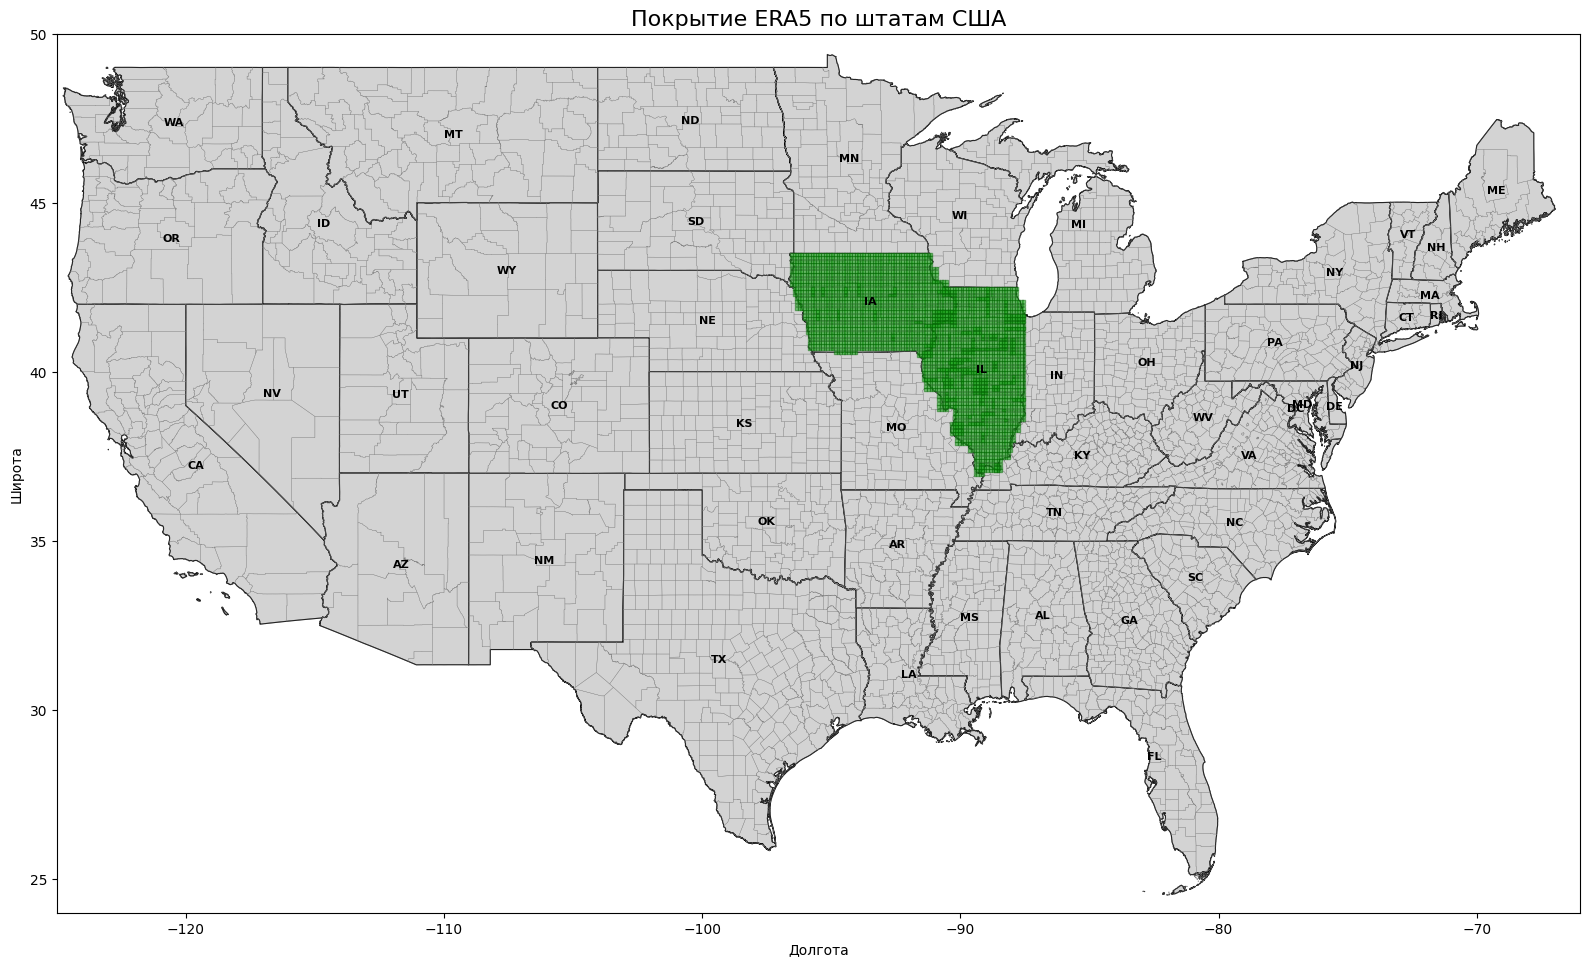

In [16]:
plot_map_polygons(polygons, "Покрытие ERA5 по штатам США")